<a href="https://colab.research.google.com/github/Yusuke-Sugihara/LSTM_Autoencoder/blob/main/LSTM_encoder_decoder_anomaly_GE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM, Input, Dropout
from keras.layers import Dense
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from keras.models import Model
import seaborn as sns

In [2]:
# dataframe = pd.read_csv('GE.csv')
# df = dataframe[['Date', 'Close']]
# df['Date'] = pd.to_datetime(df['Date'])

dataflame = pd.read_csv('GE.csv')
df = dataflame[['Date','Close']]

In [3]:
df.columns

Index(['Date', 'Close'], dtype='object')

In [4]:
df['Date'] = pd.to_datetime(df['Date'])

<ipython-input-4-b9c6864122be>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Date'] = pd.to_datetime(df['Date'])


In [5]:
df

,Date,Close
0,1962-01-02,3.731611
1,1962-01-03,3.694170
2,1962-01-04,3.650489
3,1962-01-05,3.556887
4,1962-01-08,3.550647
...,...,...
15696,2024-05-10,163.380005
15697,2024-05-13,159.500000
15698,2024-05-14,160.000000
15699,2024-05-15,163.470001


<Axes: xlabel='Date', ylabel='Close'>

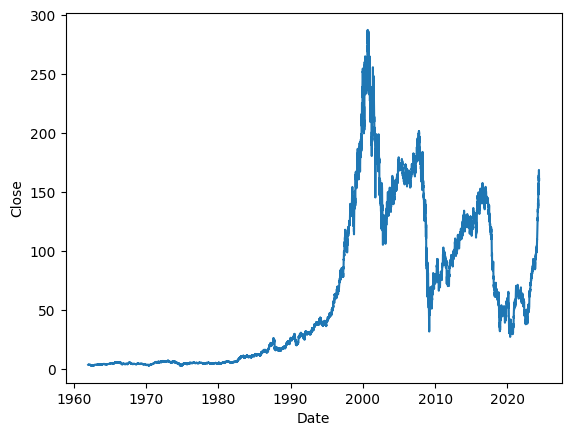

In [6]:
sns.lineplot(x=df['Date'], y=df['Close'])

In [7]:
# print("Start date is: ", df['Date'].min())
# print("End date is: ", df['Date'].max())

print("Start date is:", df['Date'].min())
print("End date is:", df["Date"].max())

Start date is: 1962-01-02 00:00:00
End date is: 2024-05-16 00:00:00


In [8]:
split_index = int(len(df)*0.8)

In [9]:
split_index

12560

In [10]:
df_sorted = df.sort_values('Date')

In [11]:
df_sorted.head()

,Date,Close
0,1962-01-02,3.731611
1,1962-01-03,3.694170
2,1962-01-04,3.650489
3,1962-01-05,3.556887
4,1962-01-08,3.550647


In [12]:
train, test = df_sorted.iloc[:split_index], df_sorted.iloc[split_index:]

In [13]:
len(train),len(test)

(12560, 3141)

In [14]:
scaler = StandardScaler()
scaler = scaler.fit(train[['Close']])

In [15]:
train['Close'] = scaler.transform(train[['Close']])
test['Close'] = scaler.transform(test[['Close']])

<ipython-input-15-c7bfe784ac5d>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['Close'] = scaler.transform(train[['Close']])
<ipython-input-15-c7bfe784ac5d>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Close'] = scaler.transform(test[['Close']])


In [16]:
train.head()

,Date,Close
0,1962-01-02,-0.734727
1,1962-01-03,-0.735278
2,1962-01-04,-0.735920
3,1962-01-05,-0.737297
4,1962-01-08,-0.737389


In [17]:
train.describe()

,Date,Close
count,12560,12560.000000
mean,1986-12-23 12:02:03.821656,0.000000
min,1962-01-02 00:00:00,-0.748863
25%,1974-07-25 18:00:00,-0.712513
50%,1986-12-27 12:00:00,-0.552793
75%,1999-06-01 06:00:00,0.444445
max,2011-11-18 00:00:00,3.440198
std,NaN,1.000040


In [18]:
#As required for LSTM networks, we require to reshape an input data into n_samples x timesteps x n_features.
#In this example, the n_features is 2. We will make timesteps = 3.
#With this, the resultant n_samples is 5 (as the input data has 9 rows).

seq_size = 30  # Number of time steps to look back
#Larger sequences (look further back) may improve forecasting.


In [19]:
def to_sequences(x, y, seq_size=1):
    x_values = []
    y_values = []

    for i in range(len(x)-seq_size):
        #print(i)
        x_values.append(x.iloc[i:(i+seq_size)].values)
        y_values.append(y.iloc[i+seq_size])

    return np.array(x_values), np.array(y_values)

trainX, trainY = to_sequences(train[['Close']], train['Close'], seq_size)
testX, testY = to_sequences(test[['Close']], test['Close'], seq_size)


In [38]:
trainX.shape, trainY.shape

((12530, 30, 1), (12530,))

In [39]:
testX.shape, testY.shape

((3111, 30, 1), (3111,))

In [41]:
train.shape, test.shape

((12560, 2), (3141, 2))

In [22]:
trainX.shape[1], trainX.shape[2]

(30, 1)

In [23]:
#Try another model
model = Sequential()
model.add(LSTM(128, input_shape=(trainX.shape[1], trainX.shape[2])))
model.add(Dropout(rate=0.2))

model.add(RepeatVector(trainX.shape[1]))

model.add(LSTM(128, return_sequences=True))
model.add(Dropout(rate=0.2))
model.add(TimeDistributed(Dense(trainX.shape[2])))
model.compile(optimizer='adam', loss='mae')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 128)               66560     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 repeat_vector (RepeatVecto  (None, 30, 128)           0         
 r)                                                              
                                                                 
 lstm_1 (LSTM)               (None, 30, 128)           131584    
                                                                 
 dropout_1 (Dropout)         (None, 30, 128)           0         
                                                                 
 time_distributed (TimeDist  (None, 30, 1)             129       
 ributed)                                               

In [26]:
history = model.fit(trainX, trainY, epochs=50, batch_size=32, validation_split=0.1, verbose=1)


Epoch 1/50
353/353 [==============================] - 5s 13ms/step - loss: 0.6190 - val_loss: 1.4298
Epoch 2/50
353/353 [==============================] - 3s 8ms/step - loss: 0.6189 - val_loss: 1.4656
Epoch 3/50
353/353 [==============================] - 3s 7ms/step - loss: 0.6190 - val_loss: 1.4521
Epoch 4/50
353/353 [==============================] - 3s 7ms/step - loss: 0.6187 - val_loss: 1.4051
Epoch 5/50
353/353 [==============================] - 3s 8ms/step - loss: 0.6189 - val_loss: 1.4623
Epoch 6/50
353/353 [==============================] - 3s 10ms/step - loss: 0.6188 - val_loss: 1.4403
Epoch 7/50
353/353 [==============================] - 3s 7ms/step - loss: 0.6191 - val_loss: 1.4388
Epoch 8/50
353/353 [==============================] - 3s 7ms/step - loss: 0.6189 - val_loss: 1.4050
Epoch 9/50
353/353 [==============================] - 3s 7ms/step - loss: 0.6190 - val_loss: 1.4379
Epoch 10/50
353/353 [==============================] - 3s 8ms/step - loss: 0.6186 - val_loss: 1.40

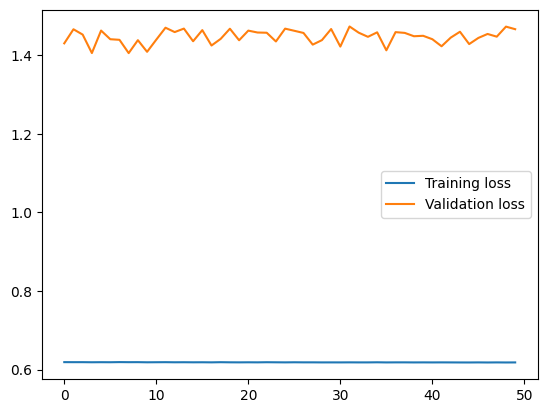

In [27]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()

392/392 [==============================] - 2s 5ms/step
trainPredict shape:(12530, 30, 1)
trainMAE shape(12530, 1)


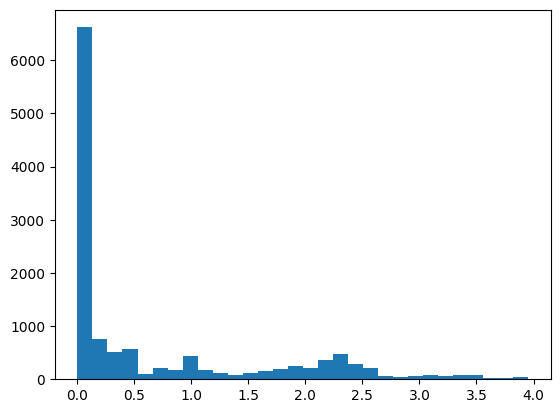

In [49]:
 ###########################
#Anomaly is where reconstruction error is large.
#We can define this value beyond which we call anomaly.
#Let us look at MAE in training prediction

trainPredict = model.predict(trainX)
print(f'trainPredict shape:{trainPredict.shape}')
trainMAE = np.mean(np.abs(trainPredict - trainX), axis=1)
print(f'trainMAE shape{trainMAE.shape}')
plt.hist(trainMAE, bins=30)
max_trainMAE = 2.0  #or Define 90% value of max as threshold.

98/98 [==============================] - 0s 3ms/step
testPredict shape:(3111, 30, 1)
testMAE shape: (3111, 1)


(array([153.,  41., 133., 151., 156., 120., 173., 216., 125.,  28.,  25.,
         42.,  61., 139., 104.,  52.,  95.,  56., 101., 103., 111., 223.,
        174.,  87.,  45.,  86., 168.,  92.,  45.,   6.]),
 array([0.31164858, 0.37387297, 0.43609737, 0.49832176, 0.56054615,
        0.62277054, 0.68499494, 0.74721933, 0.80944372, 0.87166811,
        0.93389251, 0.9961169 , 1.05834129, 1.12056569, 1.18279008,
        1.24501447, 1.30723886, 1.36946326, 1.43168765, 1.49391204,
        1.55613643, 1.61836083, 1.68058522, 1.74280961, 1.805034  ,
        1.8672584 , 1.92948279, 1.99170718, 2.05393157, 2.11615597,
        2.17838036]),
 <BarContainer object of 30 artists>)

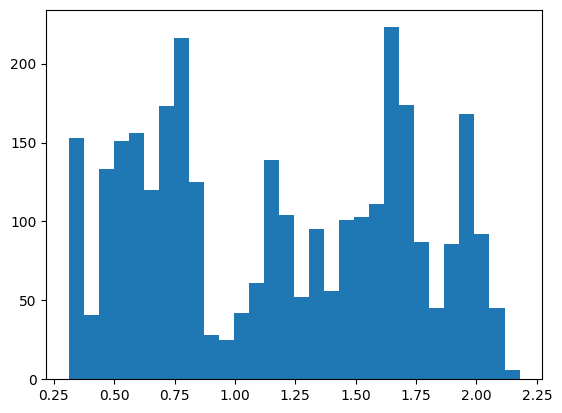

In [50]:
testPredict = model.predict(testX)
print(f'testPredict shape:{testPredict.shape}')
testMAE = np.mean(np.abs(testPredict - testX), axis=1)
print(f'testMAE shape: {testMAE.shape}')
plt.hist(testMAE, bins=30)

In [36]:
#Capture all details in a DataFrame for easy plotting
anomaly_df = pd.DataFrame(test[seq_size:])
anomaly_df

,Date,Close
12590,2012-01-05,0.518099
12591,2012-01-06,0.525149
12592,2012-01-09,0.539953
12593,2012-01-10,0.530084
12594,2012-01-11,0.541363
...,...,...
15696,2024-05-10,1.613707
15697,2024-05-13,1.556632
15698,2024-05-14,1.563987
15699,2024-05-15,1.615031


In [58]:
anomaly_df['testMAE'] = testMAE
anomaly_df['max_trainMAE'] = max_trainMAE
anomaly_df['anomaly'] = anomaly_df['testMAE'] > anomaly_df['max_trainMAE']
anomaly_df['Close'] = test[seq_size:]['Close']

In [59]:
anomaly_df

,Date,Close,testMAE,max_trainMAE,anomaly
12590,2012-01-05,0.518099,1.011818,2.0,False
12591,2012-01-06,0.525149,1.019671,2.0,False
12592,2012-01-09,0.539953,1.028275,2.0,False
12593,2012-01-10,0.530084,1.037963,2.0,False
12594,2012-01-11,0.541363,1.047490,2.0,False
...,...,...,...,...,...
15696,2024-05-10,1.613707,2.136948,2.0,True
15697,2024-05-13,1.556632,2.148607,2.0,True
15698,2024-05-14,1.563987,2.158386,2.0,True
15699,2024-05-15,1.615031,2.169849,2.0,True


<Axes: xlabel='Date', ylabel='testMAE'>

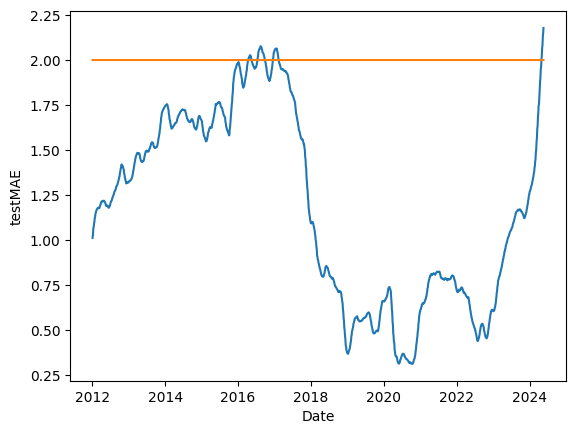

In [60]:
#Plot testMAE vs max_trainMAE
sns.lineplot(x=anomaly_df['Date'], y=anomaly_df['testMAE'])
sns.lineplot(x=anomaly_df['Date'], y=anomaly_df['max_trainMAE'])

In [66]:
anomalies = anomaly_df.loc[anomaly_df['anomaly'] == True]

In [69]:
anomaly_df_close_2d = anomaly_df['Close'].values.reshape(-1, 1)
anomalies_close_2d = anomalies['Close'].values.reshape(-1, 1)

print(anomaly_df_close_2d.shape)
print(anomalies_close_2d.shape)

(3111, 1)
(130, 1)


In [70]:
anomaly_df['Close_original'] = scaler.inverse_transform(anomaly_df_close_2d)
anomalies['Close_original'] = scaler.inverse_transform(anomalies_close_2d)

<ipython-input-70-343fd7285909>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  anomalies['Close_original'] = scaler.inverse_transform(anomalies_close_2d)


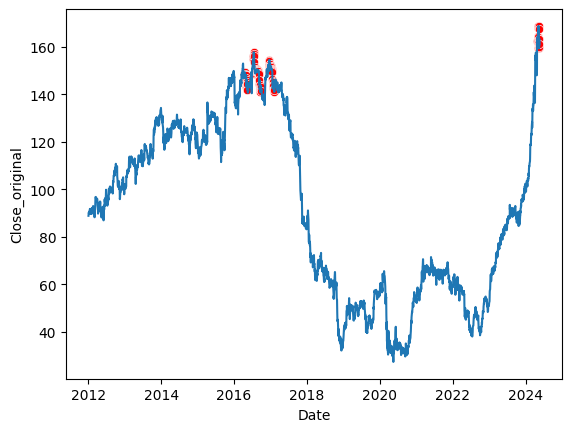

In [72]:
sns.lineplot(x=anomaly_df['Date'], y=anomaly_df['Close_original'])
sns.scatterplot(x=anomalies['Date'], y=anomalies['Close_original'], color='r')
plt.show()